In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

# from pyod.models.xgbod import XGBOD
# from sentence_transformers import SentenceTransformer
# conda install pyod 
# conda install xgboost

For other models such as PReNet or DevNet, u need to make a new environment and download/ lcone from github to run these models 

Maybe build a model that can assign labels to unlabled data of fraud or not, and  then pass it into main model so we can work with labeled and unlabled data  

In [2]:
train=pd.read_csv('/Users/mariusnwobi/Downloads/PNC_Capstone/NLP/task-specific-datasets/banking_data/train.csv')
test= pd.read_csv('/Users/mariusnwobi/Downloads/PNC_Capstone/NLP/task-specific-datasets/banking_data/test.csv')

In [17]:
train[train['category']=='wrong_amount_of_cash_received']

,text,category,class
2331,Why did I only receive a partial amount of wha...,wrong_amount_of_cash_received,1
2332,my atm transaction was wrong,wrong_amount_of_cash_received,1
2333,why did i only get 20.00,wrong_amount_of_cash_received,1
2334,Why is my cash request and the amount I receiv...,wrong_amount_of_cash_received,1
2335,"I tried to withdraw $100, all it gave me was $20.",wrong_amount_of_cash_received,1
...,...,...,...
2506,So I just went to the ATM to get some cash. I...,wrong_amount_of_cash_received,1
2507,The amount of money I pushed at the atm machin...,wrong_amount_of_cash_received,1
2508,"I got less than what i asked for in the ATM, why?",wrong_amount_of_cash_received,1
2509,I'm stuck here at your broken ATM and I don't ...,wrong_amount_of_cash_received,1


In [3]:
train['category'].value_counts()

category
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
                                                   ... 
lost_or_stolen_card                                  82
card_swallowed                                       61
card_acceptance                                      59
virtual_card_not_working                             41
contactless_not_working                              35
Name: count, Length: 77, dtype: int64

After go back and look at labeling or orgainzing categories since this could affect modeling

In [4]:
non_anom=['card_linking','activate_my_card','visa_or_mastercard','card_linking',
          'visa_or_mastercard','country_support','supported_cards_and_currencies'
          ,'fiat_currency_support','card_acceptance','edit_personal_details'
          ,'getting_spare_card','card_about_to_expire','apple_pay_or_google_pay',
          'order_physical_card','exchange_rate','card_delivery_estimate','age_limit']
len(non_anom)

train['class']=train['category'].apply(lambda x: 0 if x in non_anom else 1 )

Usually anomalies are supposed to be less but in this case it's not 

<Axes: ylabel='Frequency'>

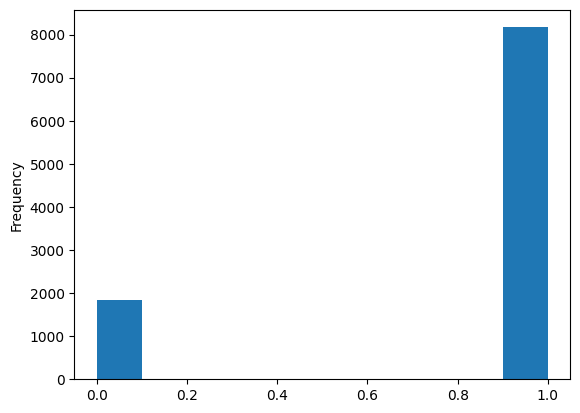

In [5]:
# 0 is non anomily and 1 is anomaly 
train['class'].plot(kind='hist')

Anything question like 

card_linking,activate_my_card,visa_or_mastercard,card_linking,visa_or_mastercard,country_support,supported_cards_and_currencies,fiat_currency_support,card_acceptance,edit_personal_details,getting_spare_card,card_about_to_expire,apple_pay_or_google_pay,order_physical_card,exchange_rate,card_delivery_estimate,age_limit


,,,,,get_disposable_virtual_card

# Plan of approach 
1.  Can start off by making the model shown in the polyai journal to create labels for you text with no labels(new new data)

2. Then try out the differnt models ranging from deep to reg Text claasisifcation models from journal. ( try out semi labled)

3. if can't make model from polyai then work on sentemin analysis and try to do fraud dectection from there based on sentiment. 

4. can also try ensemble method with mult models, mult models with sentiment and text, or mult models based on text for example. 

## With TC, start off small with binary classification then try the 77 differnt classes 




# Attempting TFIDF and OneClassSVM as baseline

TFIDF will remove stop words and train test split with 80/20 

In [6]:
vectorizer = TfidfVectorizer(
    stop_words='english',
    strip_accents='unicode',
    lowercase=True
)

vec_train=vectorizer.fit_transform(train['text'])

# train test split 
train_x,test_x,train_y,test_y= train_test_split(vec_train,train['class'],train_size=.8)

In [7]:
# creating model 
model = OneClassSVM(
    kernel='linear',     # Radial basis function kernel
    gamma=0.1,        # Kernel coefficient
    nu=0.1           # Upper bound on fraction of outliers
)

# Train the model
model.fit(train_x.toarray())

# Make predictions
y_pred = model.predict(test_x.toarray())

# in this case since non anomaly is the minority ( the model thinks non anomalies is the anomalies ) or in this case the anamoly are the " non anamanious comments"

####### Orig predictions #########
y_pred = np.where(y_pred == -1, 0, 1)  

########### use anomaly scores to get predictions  ###########
anomaly_scores = model.score_samples(test_x.toarray()) # lower scores more anominous higher scores less
threshold = np.percentile(anomaly_scores, 95)  # 5th percentile as threshold ( captures the lowest scores can lower percitle to capture the most bottomist)
predictions = np.where(anomaly_scores > threshold, 0, 1)  # 1 for normal, -1 for anomalies


# or can use anomaly score directly and find x percent for cutoff  
# Convert scores to probabilities (0 to 1 scale)
normalized_scores = (anomaly_scores - np.min(anomaly_scores)) / (np.max(anomaly_scores) - np.min(anomaly_scores))
predictions_norm = np.where(normalized_scores > .5, 0, 1) 

Accuracy from model it's self

In [8]:
print(accuracy_score(test_y,y_pred))
print(classification_report(test_y,y_pred))

0.7596201899050474
              precision    recall  f1-score   support

           0       0.30      0.21      0.24       375
           1       0.83      0.89      0.86      1626

    accuracy                           0.76      2001
   macro avg       0.56      0.55      0.55      2001
weighted avg       0.73      0.76      0.74      2001



Based on anaomly scores

In [9]:
# Based on 95 percentile
print(accuracy_score(test_y,predictions))
print(classification_report(test_y,predictions))

0.7766116941529235
              precision    recall  f1-score   support

           0       0.14      0.04      0.06       375
           1       0.81      0.95      0.87      1626

    accuracy                           0.78      2001
   macro avg       0.48      0.49      0.47      2001
weighted avg       0.68      0.78      0.72      2001



Based on normalization

In [10]:
# Based on  normlization
print(accuracy_score(test_y,predictions_norm))
print(classification_report(test_y,predictions_norm))

0.511744127936032
              precision    recall  f1-score   support

           0       0.13      0.28      0.18       375
           1       0.77      0.56      0.65      1626

    accuracy                           0.51      2001
   macro avg       0.45      0.42      0.42      2001
weighted avg       0.65      0.51      0.56      2001



# Visualizing 

This can show how my threshold influences the anamoly cutoff

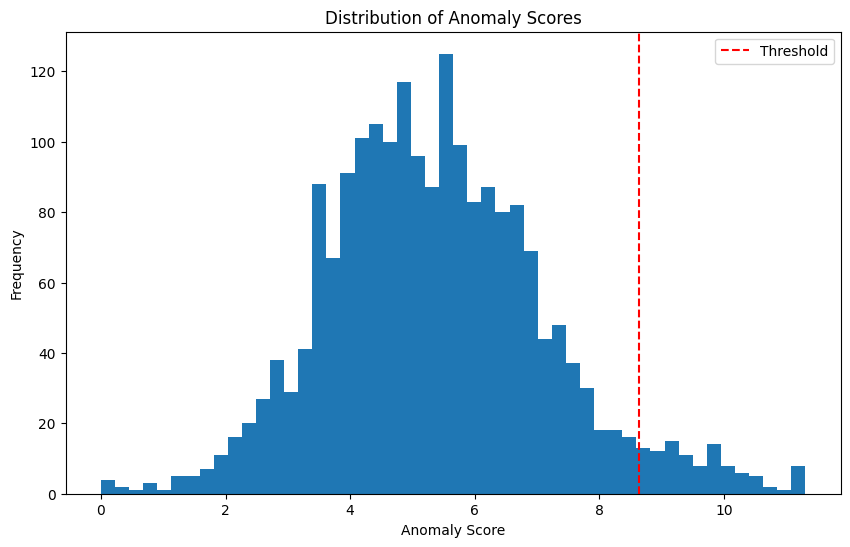

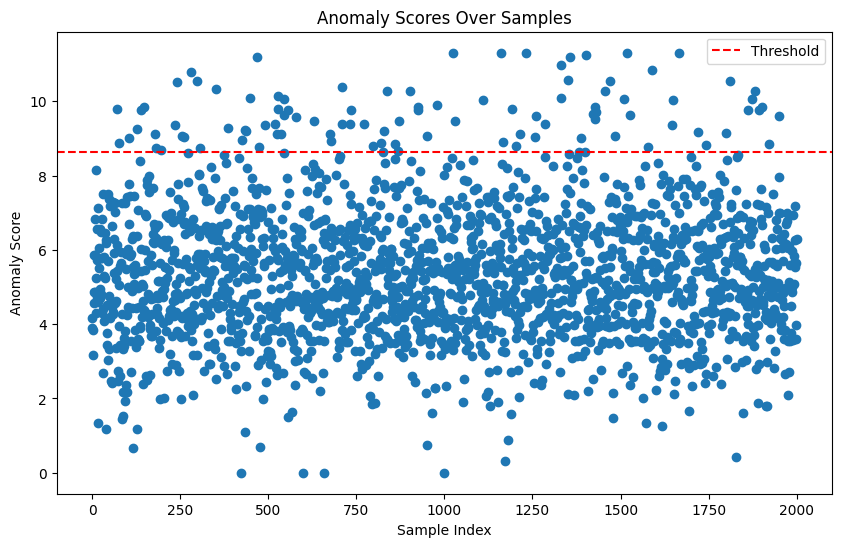

In [11]:
import matplotlib.pyplot as plt

# Plot score distribution
plt.figure(figsize=(10, 6))
plt.hist(anomaly_scores, bins=50)
plt.axvline(x=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot scores over time
plt.figure(figsize=(10, 6))
plt.scatter(range(0,len(anomaly_scores)),anomaly_scores)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Anomaly Scores Over Samples')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()


ROC curve


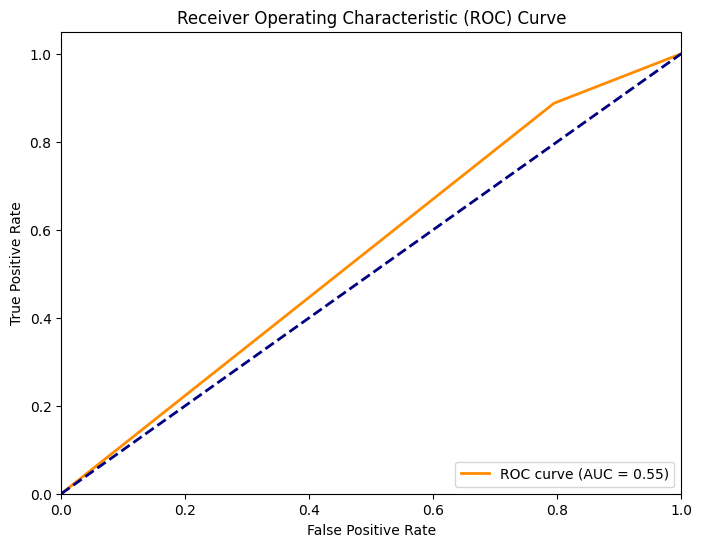

In [12]:
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


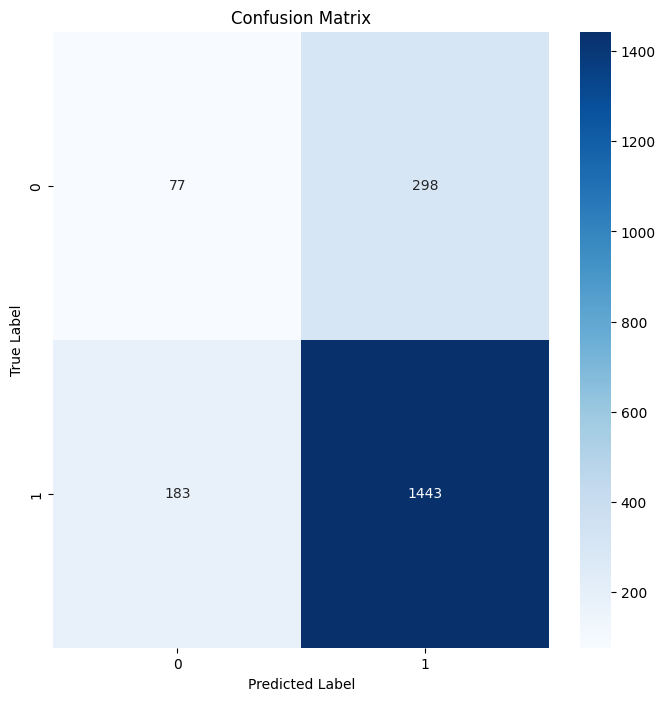

In [13]:
cm = confusion_matrix(test_y, y_pred)

# Create visualization
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Overall model isn't good due to lack of ability to detect or label anamolies 

# another way to get threshold

In [80]:
# Get top N anomalies
top_n = 10
top_anomaly_indices = np.argsort(anomaly_scores)[:top_n]
top_anomaly_scores = anomaly_scores[top_anomaly_indices]

# Calculate confidence scores (higher score = more likely to be normal)
confidence_scores = 1 - normalized_scores

0.2178910544727636

# Results  
As a result we can see we can currentl see that the model is terrbile. we should go back and revise how we're creating our labels since we have more anomlies than actual normal text which should be the other way around  

change number of steps for R hw 